# Test of `RSD` class

Compute the galaxy power spectrum in redshift space.

In [1]:
import colibri.cosmology as cc
import colibri.RSD as rsd
import colibri.constants
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec


plt.rc('text', usetex=True)
plt.rc('font', family = 'serif', size = 18)

Main settings

In [2]:
# Use a single or more (3 of default) redshifts
multiple_redshifts = True
if multiple_redshifts: zz = np.array([0., 1., 2.])
else:                  zz = np.atleast_1d(0.)

# Colors for different multipoles
colors             = ['b', 'r', 'g', 'y', 'k', 'c']

# Choose RSD model among:
#  - 'linear'     (use linear power spectrum)
#  - 'nonlinear'  (use nonlinear power spectrum with Halofit)
#  - 'HOD'        (use HOD for the real space galaxy power spectrum)
#  - 'halo model' (use halo model directly in redshift-space)
RSD_model          = 'nonlinear'

### Cosmology instance

In [3]:
C      = cc.cosmo()

### `RSD` instance

In [4]:
Z = rsd.RSD(z            = zz,                             # Redshift
            k            = np.geomspace(0.0005, 10., 201), # Scales in h/Mpc
            mu           = np.linspace(0., 1., 31),        # Cosine of angles with LOS
            k_par        = np.linspace(0.01, 1., 51),      # Scales parallel in h/Mpc
            k_perp       = np.linspace(0.01, 1., 31),      # Scales perpendicular in h/Mpc
            BAO_smearing = True,                           # Smooth BAO feature in non-linearities
            cosmology    = C)                              # Cosmology
print(">> RSD instance loaded")

>> RSD instance loaded


Redshift, biases, velocity dispersions, HOD models and growth factors

In [5]:
if multiple_redshifts:
    bb = [1.30, 2.60, 3.34]     # Galaxy biases
    ff = C.Omega_m_z(zz)**0.55  # Growth rates
    sv = [200., 200., 200.]     # Velocity dispersions (in km/s)
    # Functions to define HODs
    # (defined in the class, can be substituted by any user-defined function whose first argument is redshift)
    HOD_central_kind, HOD_satellite_kind = Z.logistic_function, Z.power_law
    # Parameters of HOD for centrals for each redshift
    HOD_central_parameters   = {'log_Mmin': [12., 12.5, 12.],
                                'sigma_logM': [0.8, 0.5, 0.2]},
    # Parameters of HOD for satellites for each redshift
    HOD_satellite_parameters = {'log_Mcut': [13., 12.5, 12.],
                                'log_M1': [14., 13.2, 13.4],
                                'alpha': [1., 1.25, 1.5]},
    # Kind of damping due to fingers-of-God (choose between 'Lorentzian' and 'Gaussian')
    FoG_damping = 'Lorentzian'
else:
    bb = np.atleast_1d(1.30)
    ff = np.atleast_1d(C.Omega_m_z(zz)**0.55)
    sv = np.atleast_1d(200.)
    HOD_central_kind, HOD_satellite_kind = Z.logistic_function, Z.power_law
    HOD_central_parameters   = {'log_Mmin': 12., 'sigma_logM': 0.5}
    HOD_satellite_parameters = {'log_Mcut':14., 'log_M1': 13., 'alpha': 1.}
    FoG_damping = 'Lorentzian'


Grid of scales (absolute, perpendicular and parallel), angles, multipoles

In [6]:
# Grid of scales and angles
K, MU         = np.meshgrid(Z.k, Z.mu, indexing = 'ij')
# Grid of parallel and perpendicular scales
K_PAR, K_PERP = np.meshgrid(Z.k_par, Z.k_perp, indexing = 'ij')
# List of multipoles (monopole, quadrupole, hexadecapole)
multipoles = [0, 2, 4]

#### Compute redshift-space power spectrum in `(k,mu)` space

In [7]:
Z.galaxy_RSD_Pk(bias                 = bb,                       # Galaxy bias (used only if model = 'HOD' or 'halo model')
                growth_rate          = ff,                       # Growth rate f = dln(D)/dln(a)
                velocity_dispersion  = sv,                       # Average velocity dispersion of galaxies in halos
                model                = RSD_model,                # Model to compute RSD
                kwargs_mass_function = {'a': 0.707, 'p': 0.3},   # Parameters to compute halo mass function (used only if model = 'HOD' or 'halo model')
                kwargs_concentration = {'c0': 9., 'b': 0.13},    # Parameters to compute concentration parameter (used only if model = 'HOD' or 'halo model')
                fingers_of_god       = FoG_damping,              # Kind of damping ('Lorentzian' or 'Gaussian', used only if model != 'halo model')
                kind_central         = HOD_central_kind,         # Function to compute central galaxies (1st arguments must be mass in Msun/h)
                kwargs_central       = HOD_central_parameters,   # Remaining arguments to pass to kind_central
                kind_satellite       = HOD_satellite_kind,       # Function to compute satellite galaxies (1st arguments must be mass in Msun/h)
                kwargs_satellite     = HOD_satellite_parameters) # Remaining arguments to pass to kind_satellite

Pk_k_mu = Z.Pk['galaxies']['redshift space']['k-mu']
print(">> P_g(k, mu) computed")

>> P_g(k, mu) computed


#### Compute redshift-space power spectrum in multipoles space

In [8]:
Z.galaxy_RSD_Pk_multipoles(l                    = multipoles,               # Multipoles to compute
                           bias                 = bb,                       # Galaxy bias (used only if 'HOD' or 'halo model')
                           growth_rate          = ff,                       # Growth rate f = dln(D)/dln(a)
                           velocity_dispersion  = sv,                       # Average velocity dispersion of galaxies in halos
                           model                = RSD_model,                # Model to compute RSD
                           kwargs_mass_function = {'a': 0.707, 'p': 0.3},   # Parameters to compute halo mass function (used only if 'HOD' or 'halo model')
                           kwargs_concentration = {'c0': 9., 'b': 0.13},    # Parameters to compute concentration parameter (used only if 'HOD' or 'halo model')
                           fingers_of_god       = FoG_damping,              # Kind of damping (used only if not 'halo model')
                           kind_central         = HOD_central_kind,         # Function to compute central galaxies (1st arguments must be mass in Msun/h)
                           kwargs_central       = HOD_central_parameters,   # Remaining arguments to pass to kind_central
                           kind_satellite       = HOD_satellite_kind,       # Function to compute satellite galaxies (1st arguments must be mass in Msun/h)
                           kwargs_satellite     = HOD_satellite_parameters) # Remaining arguments to pass to kind_satellite
print(">> P_g^(ell)(k) computed")

>> P_g^(ell)(k) computed


#### Compute redshift-space power spectrum in `(k_perp, k_par)` space

In [9]:
Z.galaxy_RSD_Pk_2D(bias                 = bb,                      # Galaxy bias (used only if 'HOD' or 'halo model')
                  growth_rate          = ff,                       # Growth rate f = dln(D)/dln(a)
                  velocity_dispersion  = sv,                       # Average velocity dispersion of galaxies in halos
                  model                = RSD_model,                # Model to compute RSD
                  kwargs_mass_function = {'a': 0.707, 'p': 0.3},   # Parameters to compute halo mass function (used only if 'HOD' or 'halo model')
                  kwargs_concentration = {'c0': 9., 'b': 0.13},    # Parameters to compute concentration parameter (used only if 'HOD' or 'halo model')
                  fingers_of_god       = FoG_damping,              # Kind of damping (used only if not 'halo model')
                  kind_central         = HOD_central_kind,         # Function to compute central galaxies (1st arguments must be mass in Msun/h)
                  kwargs_central       = HOD_central_parameters,   # Remaining arguments to pass to kind_central
                  kind_satellite       = HOD_satellite_kind,       # Function to compute satellite galaxies (1st arguments must be mass in Msun/h)
                  kwargs_satellite     = HOD_satellite_parameters) # Remaining arguments to pass to kind_satellite
Pk_k_par_k_perp = Z.Pk['galaxies']['redshift space']['k_par-k_perp']
print(">> P_g^(k_par, k_perp) computed")

>> P_g^(k_par, k_perp) computed


### Plot

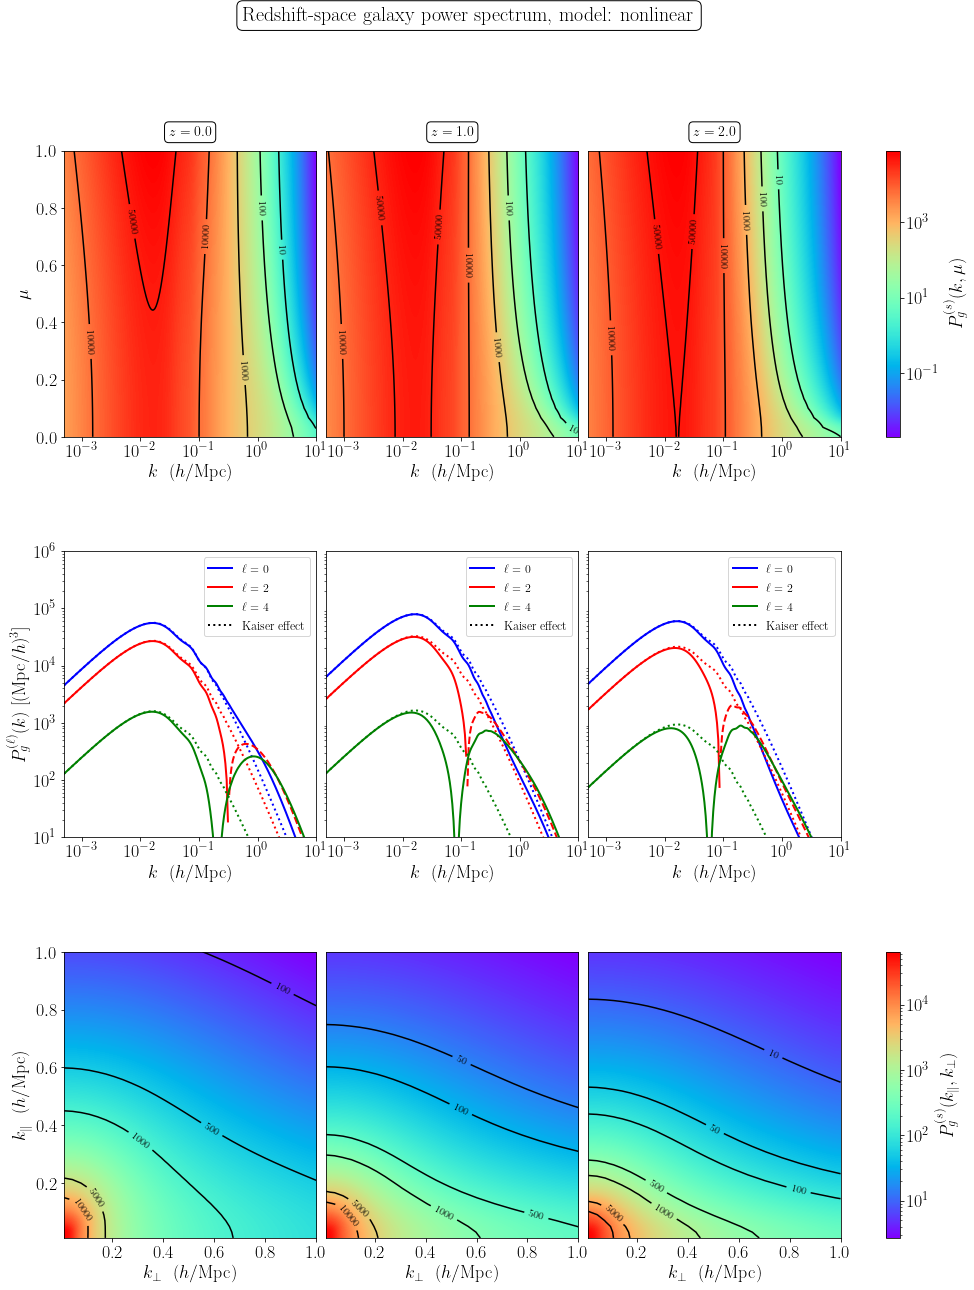

In [13]:
#---------------------
# Initialize grid for plots
#---------------------
if multiple_redshifts: fig = plt.figure(figsize = (15,20))
else:                  fig = plt.figure(figsize = (15,20))
G   = gridspec.GridSpec(3,len(zz)+1, width_ratios = [1. for i in range(len(zz))]+[0.2], figure = fig, wspace = 0.05, hspace = 0.4)
fig.suptitle("Redshift-space galaxy power spectrum, model: %s" %RSD_model, fontsize = 20, bbox = dict(boxstyle='round', facecolor='white', alpha = 1.0))
#---------------------

#---------------------
# Plotting (k, mu) space
#---------------------
for iz in range(len(zz)+1):
    ax = fig.add_subplot(G[0, iz])
    # Colorbar
    if iz == len(zz):
        ax.axis('off')
        cbar = fig.colorbar(CF, ax=ax, shrink = 1., fraction = 0.3)
        cbar.set_label('$P_g^{(s)}(k, \\mu)$')
    else:
        # Title
        ax.set_title('$z=%.1f$' %zz[iz], bbox = dict(boxstyle='round', facecolor='white', alpha = 1.0), fontsize = 14, pad = 15)
        # Contour lines
        CS = ax.contour(np.log10(K), MU, Pk_k_mu[iz],
                    norm = LogNorm(),
                    colors = 'k',
                    levels = [10,100,1000,10000,50000],
                    )
        ax.clabel(CS, fmt = '%.0f', fontsize = 10)

        # Color map
        CF = ax.imshow(np.transpose(Pk_k_mu[iz]), 
                       cmap = 'rainbow',
                       aspect = 'auto',
                       #vmin = 1e1, vmax = 1e5,
                       norm = LogNorm(), 
                       interpolation = 'bicubic', 
                       origin = 'lower', 
                       extent = (np.log10(Z.k.min()), np.log10(Z.k.max()), Z.mu.min(), Z.mu.max()))        

        # Axis settings
        ax.set_xlabel('$k$ \ ($h/\mathrm{Mpc}$)')
        if iz == 0:
            ax.set_ylabel('$\\mu$')
        else:
            ax.set_yticks([])
        ax.set_xticks([-3., -2., -1., 0., 1.])
        ax.set_xticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^0$','$10^1$'])
#---------------------

#---------------------
# Plotting multipole space
#---------------------
for iz in range(len(zz)):
    ax = fig.add_subplot(G[1, iz])
    # Colorbar
    if iz == len(zz):
        ax.axis('off')
    else:
        for il in range(len(np.atleast_1d(multipoles))):
            # Plot multipole
            pole = Z.Pk['galaxies']['redshift space']['multipoles'][str(multipoles[il])]
            ax.loglog(Z.k[np.where(pole[iz]>=0.)],  pole[iz][np.where(pole[iz]>=0.)], c = colors[il], ls = '-',  lw = 2.0, label = '$\ell = %i$' %multipoles[il])
            ax.loglog(Z.k[np.where(pole[iz]<=0.)], -pole[iz][np.where(pole[iz]<=0.)], c = colors[il], ls = '--', lw = 2.0)
            if RSD_model != 'halo model':
                if multipoles[il] == 0:
                    ax.loglog(Z.k, Z.Pk['matter']['linear'][iz]*(bb[iz]**2. + 2./3.*ff[iz]*bb[iz] + ff[iz]**2./5.) ,'b:', markersize = 2, lw = 2.0)
                elif multipoles[il] == 2:
                    ax.loglog(Z.k, Z.Pk['matter']['linear'][iz]*(4./3.*ff[iz]*bb[iz] + ff[iz]**2.*4./7.) , 'r:', markersize = 2, lw = 2.0)
                elif multipoles[il] == 4:
                    ax.loglog(Z.k, Z.Pk['matter']['linear'][iz]*(8.*ff[iz]**2./35.) , 'g:', markersize = 2, lw = 2.0)
        if RSD_model != 'halo model':
            ax.loglog(1., 1., 'k:', markersize = 2, lw = 2.0, label = 'Kaiser effect')
        ax.legend(fontsize = 12)
        # Axis settings
        ax.set_xlim(Z.k.min(), Z.k.max())
        ax.set_ylim(1e1, 1e6)
        ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
        ax.set_xticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^0$','$10^1$'])
        ax.set_xlabel('$k$ \ ($h/\mathrm{Mpc}$)')
        if iz == 0:
            ax.set_ylabel('$P_g^{(\ell)}(k) \ [(\mathrm{Mpc}/h)^3]$')
        else:
            ax.set_yticks([])
#---------------------

#---------------------
# Plotting (k_par, k_perp) space
#---------------------
for iz in range(len(zz)+1):
    ax = fig.add_subplot(G[2, iz])
    # Colorbar
    if iz == len(zz):
        ax.axis('off')
        cbar = fig.colorbar(CF, ax = ax, shrink = 1., fraction = 0.3)
        cbar.set_label('$P_g^{(s)}(k_\parallel, k_\perp)$')
    else:
        # Contour lines
        CS = ax.contour(K_PERP, K_PAR,
                        Pk_k_par_k_perp[iz],
                        levels = [10,50,100,500,1000,5000,10000],
                        norm = LogNorm(),
                        colors = 'k'
                        )
        ax.clabel(CS, fmt = '%.0f', fontsize = 10)

        # Color map
        CF = ax.imshow(Pk_k_par_k_perp[iz], 
                       cmap = 'rainbow',
                       aspect = 'auto',
                       #vmin = 1e1, vmax = 1e5,
                       norm = LogNorm(), 
                       interpolation = 'bicubic', 
                       origin = 'lower', 
                       extent = (Z.k_perp.min(), Z.k_perp.max(),Z.k_par.min(), Z.k_par.max()))

        # Axis settings
        ax.set_xlabel('$k_\perp$ \ ($h/\mathrm{Mpc}$)')
        labels = np.linspace(0.2,1.,5)
        ax.set_xticks(labels)
        ax.set_xticklabels([str("%.1f") %i for i in labels])
        if iz == 0:
            ax.set_ylabel('$k_\parallel$ \ ($h/\mathrm{Mpc}$)')
        else:
            ax.set_yticks([])
#---------------------
plt.show()